In [105]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.exponential_moving_average import exponential_moving_average as ema
from sklearn.preprocessing import MinMaxScaler

In [106]:
df1 = pd.read_csv('merged_technology_news_data_future_3months.csv')
df2 = pd.read_csv('technology_news_data_50Daily.csv')
df3 = pd.read_csv('1201-1210_news_data.csv')

# Combine the dataframes by row
df_combined = pd.concat([df1, df2, df3], ignore_index=True)
df_combined = df_combined.sort_values(by='time_published', ascending=True).reset_index(drop=True)

# Optional: Save the combined dataframe to a new CSV file
df_combined.to_csv('combined_file.csv', index=False)
display(df_combined)

,title,url,time_published,source,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,CNH Industrial: Periodic Report on $300 Millio...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.312457,Somewhat-Bullish,"[{'ticker': 'RGBD', 'relevance_score': '0.0986..."
1,Sono Group Receives Additional Staff Determina...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.047543,Neutral,"[{'ticker': 'SEV', 'relevance_score': '0.10945..."
2,CytoSorbents Announces Resignation of Chief Fi...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:43:00,GlobeNewswire,0.121210,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0735..."
3,CytoSorbents Announces Resignation of Chief Fi...,https://www.benzinga.com/pressreleases/23/09/g...,2023-09-01 20:43:18,Benzinga,0.116318,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0709..."
4,Positioning for a Year End Rally: 3 Top Ranked...,https://www.zacks.com/commentary/2143938/posit...,2023-09-01 20:45:00,Zacks Commentary,0.296182,Somewhat-Bullish,"[{'ticker': 'LRCX', 'relevance_score': '0.2589..."
...,...,...,...,...,...,...,...
23345,Google's New Willow Chip Accelerates Time to M...,https://decrypt.co/295678/googles-new-willow-c...,2024-12-09 23:34:55,Decrypt.co,0.079230,Neutral,"[{'ticker': 'MSFT', 'relevance_score': '0.0627..."
23346,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23347,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23348,Bitcoin and Ethereum ETFs Add Billions Amid Re...,https://decrypt.co/295733/bitcoin-and-ethereum...,2024-12-10 00:50:23,Decrypt.co,0.168180,Somewhat-Bullish,"[{'ticker': 'MSTR', 'relevance_score': '0.1529..."


In [107]:
def create_processed_data_df(start, end, ticker, sentiment_csv):
    stock_df = yf.download(ticker, start=start, end=end)
    stock_df = stock_df.xs(ticker, level='Ticker', axis=1)
    stock_df['time_published'] = stock_df.index
    stock_df['time_published'] = pd.to_datetime(stock_df['time_published'])
    stock_df['time_published'] = stock_df['time_published'].dt.date

    # Adding indicators
    stock_df['RSI'] = rsi(stock_df.Close, 15)
    stock_df['EMAF'] = ema(stock_df.Close, 20)
    stock_df['EMAM'] = ema(stock_df.Close, 100)
    stock_df['EMAS'] = ema(stock_df.Close, 150)

    stock_df['Target'] = stock_df['Adj Close'] - stock_df.Open
    stock_df['Target'] = stock_df['Target'].shift(-1)

    stock_df['TargetClass'] = [1 if stock_df.Target[i] > 0 else 0 for i in range(len(stock_df))]

    stock_df['TargetNextClose'] = stock_df['Adj Close'].shift(-1)
    stock_df['TargetCloseIn2Days'] = stock_df['Adj Close'].shift(-2)
    stock_df['TargetCloseIn3Days'] = stock_df['Adj Close'].shift(-3)
    stock_df['TargetCloseIn4Days'] = stock_df['Adj Close'].shift(-4)
    stock_df['TargetCloseIn5Days'] = stock_df['Adj Close'].shift(-5)

    second_last_row = stock_df.iloc[[-2]]  # Get the second last row
    stock_df.dropna(inplace=True)
    stock_df.reset_index(inplace=True)
    stock_df = pd.concat([stock_df, second_last_row], ignore_index=True)
    stock_df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

    # Load news sentiment data
    news_df = pd.read_csv(sentiment_csv)
    news_df['time_published'] = pd.to_datetime(news_df['time_published'])
    news_df['time_published'] = news_df['time_published'].dt.date
    news_df = news_df[news_df['title'] != 'Before you continue']

    df1 = stock_df.copy(deep=True)
    df2 = news_df[['time_published', 'source', 'overall_sentiment_score']]
    average_sentiment_df = df2.groupby(['time_published', 'source'], as_index=False)['overall_sentiment_score'].mean()
    average_sentiment_df.rename(columns={'overall_sentiment_score': 'average sentiment score'}, inplace=True)
    pivot_df = average_sentiment_df.pivot(index='time_published', columns='source', values='average sentiment score')
    pivot_df.reset_index(inplace=True)
    pivot_df.fillna(-1, inplace=True)
    pivot_df.replace(-1, np.nan, inplace=True)
    combined_df = pd.merge(df1, pivot_df, on='time_published', how='inner')

    # Step 1: Calculate price movement
    combined_df['price_change'] = combined_df['Adj Close'].pct_change()  # Percentage change
    combined_df['price_movement'] = combined_df['price_change'].apply(lambda x: 'up' if x > 0 else 'down')
    news_sentiment_columns = combined_df.drop(['Adj Close', 'High', 'Low', 'Open', 'time_published', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days'], axis=1).columns.tolist()

    # Step 2: Adjust weights based on price movement
    news_sentiment_columns = [
        'Al Jareeza', 'Associated Press', 'Barrons', 'Benzinga', 'Business Insider',
        'Business Standard', 'CNBC', 'CNN', 'Canada Newswire', 'Cointelegraph',
        'Decrypt.co', 'Financial News London', 'Financial Times', 'Forbes',
        'Fox Business News', 'GlobeNewswire', 'Investing News Network',
        'Investor Ideas', 'Investors Business Daily', 'Kiplinger', 'MarketWatch',
        'Money Control', 'Money Morning', 'Motley Fool', 'New York Times',
        'PR Newswire', 'PennyStocks.com', 'Reuters', 'South China Morning Post',
        'StockMarket.com', 'Stocknews.com', 'The Atlantic', 'The Economist',
        'The Financial Express', 'The Street', 'The Week News', 'UPI Business',
        'Wall Street Journal', 'Zacks Commentary'
    ]

    source_weights = {source: 1.0 for source in news_sentiment_columns}  # Default weights

    def adjust_weights(row):
        price_movement = row['price_movement']
        price_change = abs(row['price_change'])  # Magnitude of price change
        adjusted_weights = source_weights.copy()  # Start with default weights

        # Adjust the weight for each source
        for source in news_sentiment_columns:
            if price_movement == 'up':
                adjusted_weights[source] += 0.1  # Increase weight when price goes up
            elif price_movement == 'down':
                adjusted_weights[source] -= 0.1  # Decrease weight when price goes down

        return adjusted_weights

    combined_df['adjusted_weights'] = combined_df.apply(adjust_weights, axis=1)

    # Step 3: Apply the adjusted weights to the sentiment values
    weighted_sentiments = combined_df[news_sentiment_columns].copy()
    for idx, source in enumerate(news_sentiment_columns):
        weighted_sentiments[source] = combined_df.apply(
            lambda row: row[source] * row['adjusted_weights'][source], axis=1)

    # Step 4: Calculate aggregate weighted sentiment
    combined_df['aggregate_weighted_sentiment'] = weighted_sentiments.mean(axis=1)
    second_last_row, second_last_row_date = combined_df.iloc[[-1]], combined_df.iloc[[-1]]['time_published'].values
    # Final DataFrame with weighted sentiment included
    final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'aggregate_weighted_sentiment', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days']]

    time_published = combined_df['time_published'].values

    # Return the processed final dataframe, time_published, and the second last row with date
    return final_df, time_published, (second_last_row, second_last_row_date)

In [108]:
# def create_processed_data_df(start, end, ticker, sentiment_csv):
#     stock_df = yf.download(ticker, start=start, end=end)
#     stock_df = stock_df.xs(ticker, level='Ticker', axis=1)
#     stock_df['time_published'] = stock_df.index
#     stock_df['time_published'] = pd.to_datetime(stock_df['time_published'])
#     stock_df['time_published'] = stock_df['time_published'].dt.date

#     # Adding indicators
#     stock_df['RSI'] = rsi(stock_df.Close, 15)
#     stock_df['EMAF'] = ema(stock_df.Close, 20)
#     stock_df['EMAM'] = ema(stock_df.Close, 100)
#     stock_df['EMAS'] = ema(stock_df.Close, 150)

#     stock_df['Target'] = stock_df['Adj Close'] - stock_df.Open
#     stock_df['Target'] = stock_df['Target'].shift(-1)

#     stock_df['TargetClass'] = [1 if stock_df.Target[i] > 0 else 0 for i in range(len(stock_df))]

#     stock_df['TargetNextClose'] = stock_df['Adj Close'].shift(-1)
#     stock_df['TargetCloseIn2Days'] = stock_df['Adj Close'].shift(-2)
#     stock_df['TargetCloseIn3Days'] = stock_df['Adj Close'].shift(-3)
#     stock_df['TargetCloseIn4Days'] = stock_df['Adj Close'].shift(-4)
#     stock_df['TargetCloseIn5Days'] = stock_df['Adj Close'].shift(-5)

#     second_last_row = stock_df.iloc[[-2]]  # Get the second last row
#     stock_df.dropna(inplace=True)
#     stock_df.reset_index(inplace=True)
#     stock_df = pd.concat([stock_df, second_last_row], ignore_index=True)
#     stock_df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

#     # Load news sentiment data
#     news_df = pd.read_csv(sentiment_csv)
#     news_df['time_published'] = pd.to_datetime(news_df['time_published'])
#     news_df['time_published'] = news_df['time_published'].dt.date
#     news_df = news_df[news_df['title'] != 'Before you continue']

#     df1 = stock_df.copy(deep=True)
#     df2 = news_df[['time_published', 'source', 'overall_sentiment_score']]
#     average_sentiment_df = df2.groupby(['time_published', 'source'], as_index=False)['overall_sentiment_score'].mean()
#     average_sentiment_df.rename(columns={'overall_sentiment_score': 'average sentiment score'}, inplace=True)
#     pivot_df = average_sentiment_df.pivot(index='time_published', columns='source', values='average sentiment score')
#     pivot_df.reset_index(inplace=True)
#     pivot_df.fillna(-1, inplace=True)
#     pivot_df.replace(-1, np.nan, inplace=True)
#     combined_df = pd.merge(df1, pivot_df, on='time_published', how='inner')

#     # Step 1: Calculate price movement
#     combined_df['price_change'] = combined_df['Adj Close'].pct_change()  # Percentage change
#     combined_df['price_movement'] = combined_df['price_change'].apply(lambda x: 'up' if x > 0 else 'down')
#     news_sentiment_columns = combined_df.drop(['Adj Close', 'High', 'Low', 'Open', 'time_published', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days'], axis=1).columns.tolist()

#     # Step 2: Adjust weights based on price movement
#     news_sentiment_columns = [
#         'Al Jareeza', 'Associated Press', 'Barrons', 'Benzinga', 'Business Insider',
#         'Business Standard', 'CNBC', 'CNN', 'Canada Newswire', 'Cointelegraph',
#         'Decrypt.co', 'Financial News London', 'Financial Times', 'Forbes',
#         'Fox Business News', 'GlobeNewswire', 'Investing News Network',
#         'Investor Ideas', 'Investors Business Daily', 'Kiplinger', 'MarketWatch',
#         'Money Control', 'Money Morning', 'Motley Fool', 'New York Times',
#         'PR Newswire', 'PennyStocks.com', 'Reuters', 'South China Morning Post',
#         'StockMarket.com', 'Stocknews.com', 'The Atlantic', 'The Economist',
#         'The Financial Express', 'The Street', 'The Week News', 'UPI Business',
#         'Wall Street Journal', 'Zacks Commentary'
#     ]

#     source_weights = {source: 1.0 for source in news_sentiment_columns}  # Default weights

#     def adjust_weights(row):
#         price_movement = row['price_movement']
#         price_change = abs(row['price_change'])  # Magnitude of price change
#         adjusted_weights = source_weights.copy()  # Start with default weights

#         # Adjust the weight for each source
#         for source in news_sentiment_columns:
#             if price_movement == 'up':
#                 adjusted_weights[source] += 0.1 * price_change # Increase weight when price goes up
#             elif price_movement == 'down':
#                 adjusted_weights[source] -= 0.05 * price_change # Decrease weight when price goes down

#         return adjusted_weights
#     # Clean data (fill NaN with a default value or drop rows with NaN values)
#     combined_df = combined_df.dropna(subset=['price_change', 'price_movement'])


#     combined_df['adjusted_weights'] = combined_df.apply(adjust_weights, axis=1)

#     # Step 3: Apply the adjusted weights to the sentiment values
#     weighted_sentiments = combined_df[news_sentiment_columns].copy()
#     for idx, source in enumerate(news_sentiment_columns):
#         weighted_sentiments[source] = combined_df.apply(
#             lambda row: row[source] * row['adjusted_weights'][source], axis=1)

#     # Step 4: Calculate aggregate weighted sentiment
#     combined_df['aggregate_weighted_sentiment'] = weighted_sentiments.mean(axis=1)
#     second_last_row, second_last_row_date = combined_df.iloc[[-1]], combined_df.iloc[[-1]]['time_published'].values
#     # Final DataFrame with weighted sentiment included
#     final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'aggregate_weighted_sentiment', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days']]

#     time_published = combined_df['time_published'].values

#     # Return the processed final dataframe, time_published, and the second last row with date
#     return final_df, time_published, (second_last_row, second_last_row_date)

In [109]:
final_df, time_published, (second_last_row, second_last_row_date) = create_processed_data_df("2023-09-01", "2024-12-10", "QQQ", 'combined_file.csv')
# spy = yf.Ticker("SPY")
display(final_df)

[*********************100%***********************]  1 of 1 completed
/home/hwangryan/CS506_Final_Project/venv/lib/python3.10/site-packages/pyti/exponential_moving_average.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_top = data[period - 1]
/home/hwangryan/CS506_Final_Project/venv/lib/python3.10/site-packages/pyti/exponential_moving_average.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_top += ((1 - w)**idx) * data[period - 1 - idx]
/home/hwangryan/CS506_Final_Project/venv/lib/python3.10/site-packages/pyti/exponential_moving_average.py:26: FutureWarning: Series.__getitem__ treating keys as positio

,Adj Close,High,Low,Open,aggregate_weighted_sentiment,Target,TargetClass,TargetNextClose,TargetCloseIn2Days,TargetCloseIn3Days,TargetCloseIn4Days,TargetCloseIn5Days
0,439.283508,442.500000,439.200012,441.410004,0.132155,-2.051361,0,440.908630,437.060181,444.039246,436.960449,429.772003
1,440.908630,443.239990,437.440002,442.959991,0.160659,0.060181,1,437.060181,444.039246,436.960449,429.772003,429.811890
2,437.060181,439.239990,436.279999,437.000000,0.132857,3.779236,1,444.039246,436.960449,429.772003,429.811890,424.567596
3,444.039246,446.329987,437.959991,440.260010,0.117225,-4.139557,0,436.960449,429.772003,429.811890,424.567596,422.144867
4,436.960449,442.239990,436.880005,441.100006,0.145702,-12.287994,0,429.772003,429.811890,424.567596,422.144867,413.411041
...,...,...,...,...,...,...,...,...,...,...,...,...
162,509.309998,510.140015,507.230011,508.079987,0.217447,-2.870026,0,505.299988,509.739990,515.289978,516.869995,523.260010
163,505.299988,508.239990,501.929993,508.170013,0.133344,3.809998,1,509.739990,515.289978,516.869995,523.260010,521.809998
164,509.739990,510.339996,505.309998,505.929993,0.187854,4.279968,1,515.289978,516.869995,523.260010,521.809998,526.479980
165,515.289978,516.260010,510.619995,511.010010,0.165398,2.919983,1,516.869995,523.260010,521.809998,526.479980,522.380005


In [110]:
display(second_last_row)

,Adj Close,High,Low,Open,time_published,RSI,EMAF,EMAM,EMAS,Target,...,The Financial Express,The Street,The Week News,UPI Business,Wall Street Journal,Zacks Commentary,price_change,price_movement,adjusted_weights,aggregate_weighted_sentiment
166,526.47998,526.719971,522.349976,522.47998,2024-12-06,69.262484,513.322,493.325087,487.56893,-3.169983,...,NaN,NaN,NaN,NaN,NaN,0.274591,0.021716,up,"{'Al Jareeza': 1.1, 'Associated Press': 1.1, '...",0.234568


In [111]:
def create_scaled_dataset(df,  time_published, MinMaxScaler=MinMaxScaler, backcandles=30):
  sc = MinMaxScaler(feature_range=(0,1))
  # data_set_scaled = sc.fit_transform(data_set)
  # print(data_set_scaled)
  data_set = df.to_numpy()
  # multiple feature from data provided to the model
  X = []
  corresponding_times = []
  print(data_set.shape[0])
  for j in range(5):#data_set_scaled[0].size):#2 columns are target not X
      X.append([])
      for i in range(backcandles, data_set.shape[0]):#backcandles+2
          X[j].append(data_set[i-backcandles:i, j])

  for i in range(backcandles, data_set.shape[0]):  # Starting from backcandles to get the correct times
    # Append the time corresponding to the last time step of each sample
    corresponding_times.append(time_published[i])
  corresponding_times = np.array(corresponding_times)


  #move axis from 0 to position 2
  X=np.moveaxis(X, [0], [2])

  #Erase first elements of y because of backcandles to match X length
  X, yi =np.array(X), np.array(data_set[backcandles:,-5:])
  y=np.reshape(yi,(len(yi),5))
  # print(X)
  print(X.shape)
  # print(y)
  print(y.shape)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  X_shape = X.shape
  X_reshaped = X.reshape(-1, X.shape[2])

  X_reshaped_scaled = sc_X.fit_transform(X_reshaped)
  X = X_reshaped_scaled.reshape(X_shape[0], X_shape[1], -1)
  y = sc_y.fit_transform(y)
  return X, y, sc_X, sc_y, corresponding_times

In [112]:
X, y, sc_X, sc_y, corresponding_times = create_scaled_dataset(final_df, time_published, MinMaxScaler)
last_X, last_y, last_time = X[-1], y[-1], corresponding_times[-1]
X, y, corresponding_times = X[:-1, :, :], y[:-1], corresponding_times[:-1]
print(X.shape, y.shape)

167
(137, 30, 5)
(137, 5)
(136, 30, 5) (136, 5)


In [113]:
# split data into train test sets
splitlimit = 92
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
time_published_train, time_published_test = corresponding_times[:splitlimit], corresponding_times[splitlimit:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(sc_y.inverse_transform([y_train[-1]]), time_published_train[-1])
print(sc_y.inverse_transform([y_test[-1]]), time_published_test[-1])
# print(y_train)

92
(92, 30, 5) (44, 30, 5)
(92, 5) (44, 5)
[[481.26998901 481.95001221 481.58999634 487.32000732 482.1000061 ]] 2024-09-30
[[516.86999512 523.26000977 521.80999756 526.47998047 522.38000488]] 2024-12-02


In [114]:
# test_df, time_published_test = create_processed_data_df('2023-09-01', '2024-11-01', 'QQQ', 'combined_file.csv')

# X_test, y_test, sc_X_test, sc_y_test, time_published_test = create_scaled_dataset(test_df, time_published_test)
# display(time_published_test)
# # Filter test_df to only include rows with time_published > '2024-09-01'
# test_df = test_df.loc[time_published_test  > pd.to_datetime('2024-09-01')]

# # Apply the same filter to the other DataFrames using the same index from filtered test_df
# X_test = X_test.loc[test_df.index]
# y_test = y_test.loc[test_df.index]
# sc_X_test = sc_X_test.loc[test_df.index]
# sc_y_test = sc_y_test.loc[test_df.index]
# time_published_test = time_published_test.loc[test_df.index]

In [119]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(506)
backcandles = 30

lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(5, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 0.0898 - val_loss: 0.0091
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0363 - val_loss: 0.0331
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0270 - val_loss: 0.0215
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0261 - val_loss: 0.0161
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0243 - val_loss: 0.0098
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0215 - val_loss: 0.0231
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0249 - val_loss: 0.0171
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0197 - val_loss: 0.0098
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0208 - val_loss: 0.0147
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0226 - val_loss: 0.0186
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0204 - val_loss: 0.0118
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0199 - val_loss: 0.0154


In [120]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {loss}")
y_pred = model.predict(X_test)

Mean Squared Error on test set: 0.05495871230959892
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step


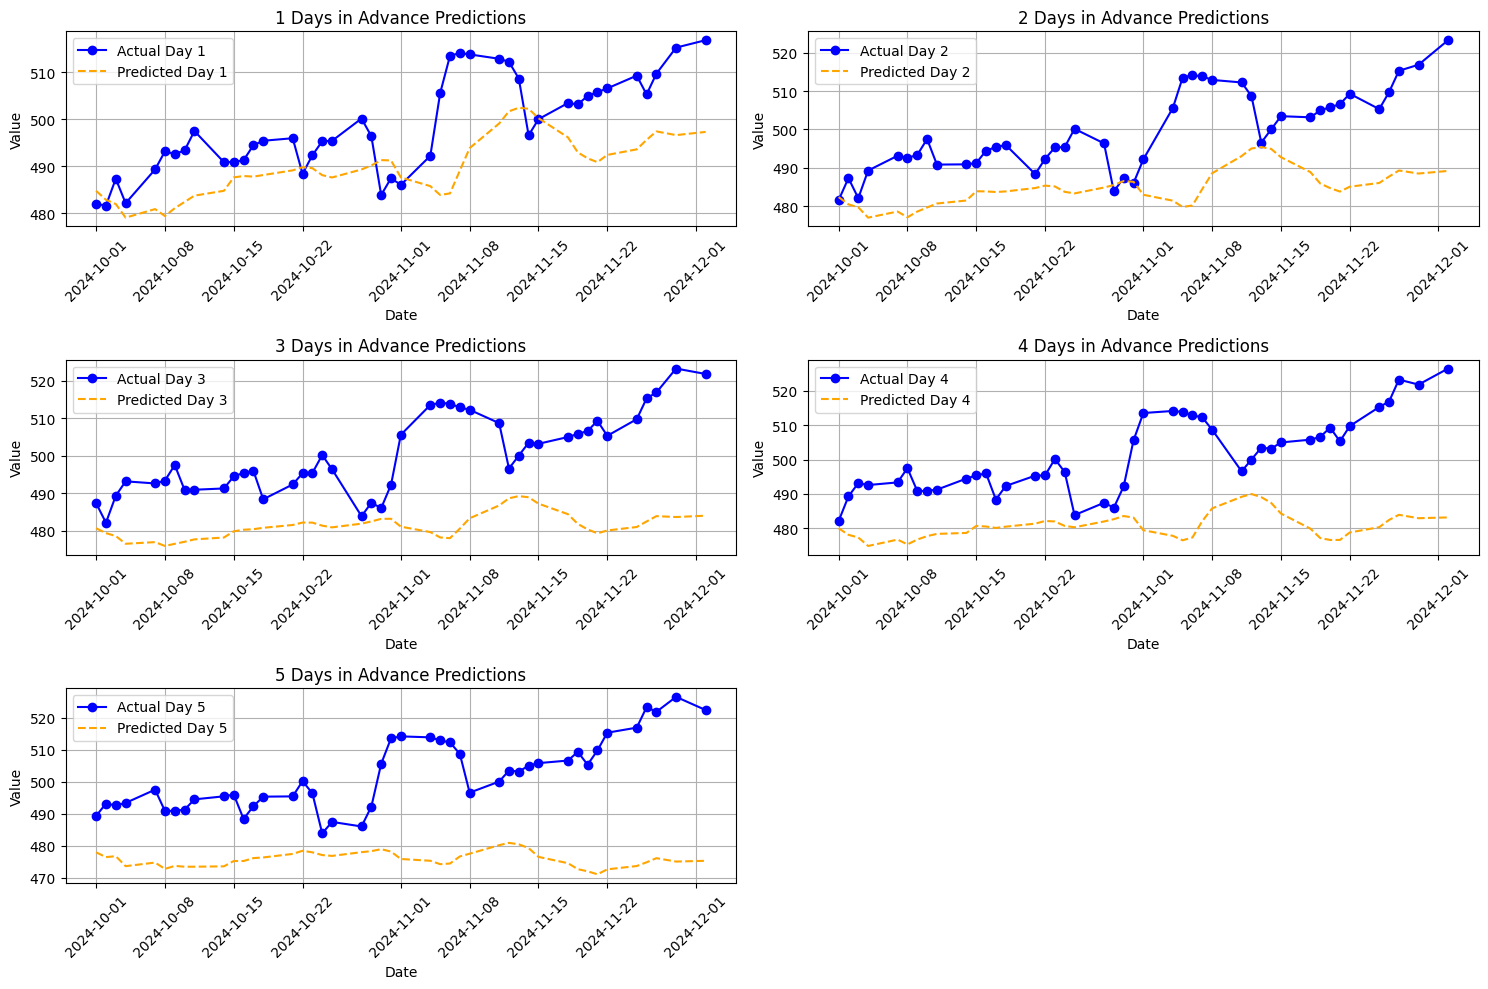

In [121]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming test_dates are the dates corresponding to X_test
num_days = 5  # Number of days ahead predictions
test_dates = pd.DataFrame(time_published_test)  # Example dates

y_test_original = sc_y.inverse_transform(y_test)
y_pred_original = sc_y.inverse_transform(y_pred)

# Create DataFrames for easier handling
y_test_df = pd.DataFrame(y_test_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])
y_pred_df = pd.DataFrame(y_pred_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])

# Plot each day individually
plt.figure(figsize=(15, 10))

for i in range(num_days):
    plt.subplot(3, 2, i + 1)  # Create a grid of 3 rows, 2 columns
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_df.iloc[:, i], label=f"Actual Day {i+1}", color="blue", linestyle="-", marker="o")
    plt.plot(test_dates, y_pred_df.iloc[:, i], label=f"Predicted Day {i+1}", color="orange", linestyle="--")
    plt.title(f"{i+1} Days in Advance Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


[datetime.datetime(2024, 12, 9, 0, 0)
 datetime.datetime(2024, 12, 10, 0, 0)
 datetime.datetime(2024, 12, 11, 0, 0)
 datetime.datetime(2024, 12, 12, 0, 0)
 datetime.datetime(2024, 12, 13, 0, 0)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
[[499.07516 490.75256 484.82596 484.29    475.4106 ]]


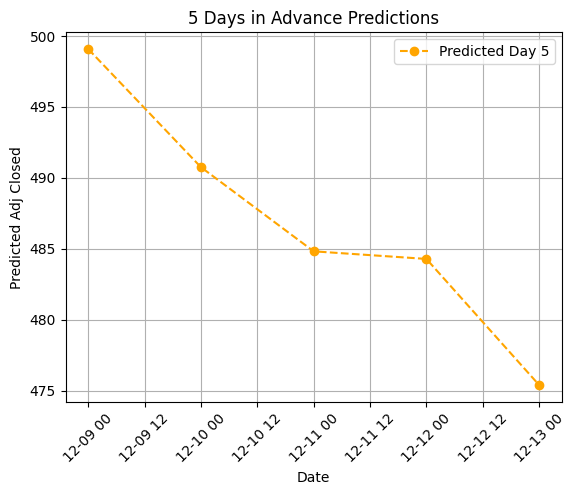

In [122]:
from datetime import datetime, timedelta

start_date = datetime(2024, 12, 9)
end_date = datetime(2024, 12, 13)

datetime_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

future_dates = np.array(datetime_list)

print(future_dates)
last_y_pred = model.predict(last_X.reshape(1, 30, 5))
last_y_pred_original = sc_y.inverse_transform(last_y_pred)
print(last_y_pred_original)

plt.xticks(rotation=45)
plt.plot(future_dates, last_y_pred_original.reshape(5,), label=f"Predicted Day {i+1}", color="orange", linestyle="--", marker="o")
plt.title(f"{i+1} Days in Advance Predictions")
plt.xlabel("Date")
plt.ylabel("Predicted Adj Closed")
plt.legend()
plt.grid()